In [48]:
import pandas as pd 

import matplotlib.pyplot as plt
# we use xgboost gradient boosting decsion trees model for this experiment 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import xgboost as xgb

import scikitplot as skplt

In [37]:
df = pd.read_csv('./data/authority_dataset.csv').rename(columns={'auth': 'authority'})
df

,ad,authority
0,north korea officially has no corona cases how...,1
1,it seems difficult to stand for something one ...,0
2,senator bernie sanders held a rally with randy...,1
3,life gets busy—don’t wait to send back your ba...,0
4,some issues feel impossible to compromise on b...,1
...,...,...
49661,a recent poll shows sherrod with just a one po...,0
49662,today’s donor goal ⃣ ⃣ ⃣ our endofquarter dead...,0
49663,you’ve been selected after a year of chaos hat...,1
49664,after receiving the corona vaccine a video tha...,0


In [38]:
# vectorize testing and training data 
X_train, X_test, y_train,  y_test = train_test_split(df['ad'], df['authority'] , test_size = 0.33, random_state = 42)

In [44]:
tf_vectorizer = TfidfVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [45]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_tf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

accuracy:   0.974
              precision    recall  f1-score   support

no-authority       0.95      1.00      0.97      8190
   authority       1.00      0.95      0.97      8200

    accuracy                           0.97     16390
   macro avg       0.98      0.97      0.97     16390
weighted avg       0.98      0.97      0.97     16390

confusion matrix:
[[8183    7]
 [ 417 7783]]



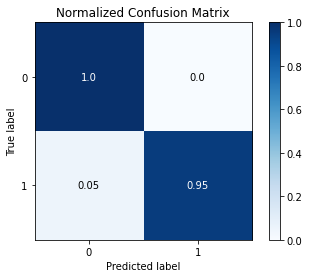

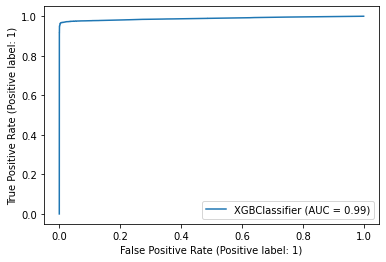

In [46]:
# predict the labels on validation dataset
predictions = xgb_clf.predict(X_test_tf)

# compute the performance measures
score1 = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_test, predictions, target_names=['no-authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
svc_disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_tf, y_test)

In [42]:
df_val = pd.read_csv('./data/sample_auth.csv')
df_val

,ad,authority
0,the european youth event is back in strasbourg...,1
1,learn the greatest tips tricks from the world...,1
2,live women leaders discuss how to accelerateeq...,1
3,if you love motorsport but work in another ind...,0
4,together we can turn the tide to protect our p...,0
...,...,...
103,it takes courage to take control of our life a...,0
104,experts from waseda university are advising ja...,1
105,a team of investigators from the rush universi...,1
106,you should recycle your jeansin the 4th episod...,1


accuracy:   0.731
              precision    recall  f1-score   support

     no-auth       0.69      0.85      0.76        54
        auth       0.80      0.61      0.69        54

    accuracy                           0.73       108
   macro avg       0.75      0.73      0.73       108
weighted avg       0.75      0.73      0.73       108

confusion matrix:
[[46  8]
 [21 33]]



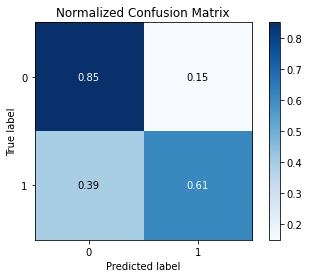

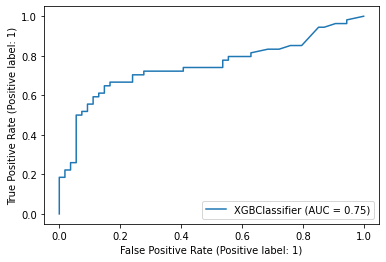

In [47]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['authority']
y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-auth', 'auth']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)